In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
import string
import requests
from bs4 import BeautifulSoup
import re

import os
import sys
from IPython.display import display, HTML
import urllib
import gzip

import nltk
from nltk import tokenize
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
import pip

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\CP\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\CP\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\CP\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


In [2]:
def cleanString(review,stopWords):
    lemmatizer = WordNetLemmatizer()
    nonan = re.compile(r'[^a-zA-Z ]')
    returnString = ""
    sentence_token = tokenize.word_tokenize(review)
    idx_list = []
    for j in range(len(sentence_token)):
        single_sentence = nonan.sub('', sentence_token[j])
        single_sentence = tokenize.word_tokenize(sentence_token[j])
        single_sentence=[lemmatizer.lemmatize(t) for t in single_sentence]
        single_sentence = [w for w in single_sentence if not w.isdigit() and not w in stopWords and not w in string.punctuation]
        single_sentence=[word for word in single_sentence if word.lower() not in stopWords]
        sentences_filtered = [(idx,lemmatizer.lemmatize(w.lower())) for idx,w in enumerate(single_sentence) 
                              if w.lower() not in stopWords and w.isalnum()]
        idx_list.append([x[0] for x in sentences_filtered])
        word_list = [x[1] for x in sentences_filtered]
        returnString = returnString + ' '.join(word_list) + ' '
    
    return returnString, idx_list

In [3]:
def split_df(dataframe, column_name, training_split = 0.6, validation_split = 0.2, test_split = 0.2):
    """
    Splits a pandas dataframe into trainingset, validationset and testset in specified ratio.
    All sets are balanced, which means they have the same ratio for each categorie as the full set.
    Input:   dataframe        - Pandas Dataframe, should include a column for data and one for categories
             column_name      - Name of dataframe column which contains the categorical output values
             training_split   - from ]0,1[, default = 0.6
             validation_split - from ]0,1[, default = 0.2        
             test_split       - from ]0,1[, default = 0.2
                                Sum of all splits need to be 1
    Output:  train            - Pandas DataFrame of trainset
             validation       - Pandas DataFrame of validationset
             test             - Pandas DataFrame of testset
    """
    if training_split + validation_split + test_split != 1.0:
        raise ValueError('Split paramter sum should be 1.0')
        
    total = len(dataframe.index)
 
    train = dataframe.reset_index().groupby(column_name).apply(lambda x: x.sample(frac=training_split))\
    .reset_index(drop=True).set_index('index')
    train = train.sample(frac=1)
    temp_df = dataframe.drop(train.index)
    validation = temp_df.reset_index().groupby(column_name)\
    .apply(lambda x: x.sample(frac=validation_split/(test_split+validation_split)))\
           .reset_index(drop=True).set_index('index')
    validation = validation.sample(frac=1)
    test = temp_df.drop(validation.index)
    test = test.sample(frac=1)
    
    print('Total: ', len(dataframe))
    print('Training: ', len(train), ', Percentage: ', len(train)/len(dataframe))
    print('Validation: ', len(validation), ', Percentage: ', len(validation)/len(dataframe))
    print('Test:', len(test), ', Percentage: ', len(test)/len(dataframe))

    return train, validation, test

In [6]:
spvl=pd.read_excel('Supervised Learning-Chatbot.xlsx',encoding =  "ISO-8859-1")

In [9]:
spvl.head(3)

,CODE,QUESTIONS,TAG
0,AASKK1,What is Supervised learning?,0
1,AASKK2,What is regression ?,0
2,AASKK3,What is slope ?,0


In [10]:
######################################
######################################

In [11]:
! pip install nltk
! pip install wordcloud

ERROR: Could not find a version that satisfies the requirement wordcloud (from versions: none)
ERROR: No matching distribution found for wordcloud


In [12]:
# General packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# NLP packages
import nltk
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
#from wordcloud import WordCloud

# Modeling packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from pylab import rcParams
import warnings
warnings.filterwarnings("ignore")
rcParams['figure.figsize'] = 14, 6
plt.style.use('ggplot')

### Reading and performing basic analysis of the data

In [17]:
spvl=pd.read_excel('Supervised Learning-Chatbot.xlsx')

In [18]:
spvl.head(3)

,CODE,Text,TAG
0,AASKK1,What is Supervised learning,0
1,AASKK2,What is regression,0
2,AASKK3,What is slope,0


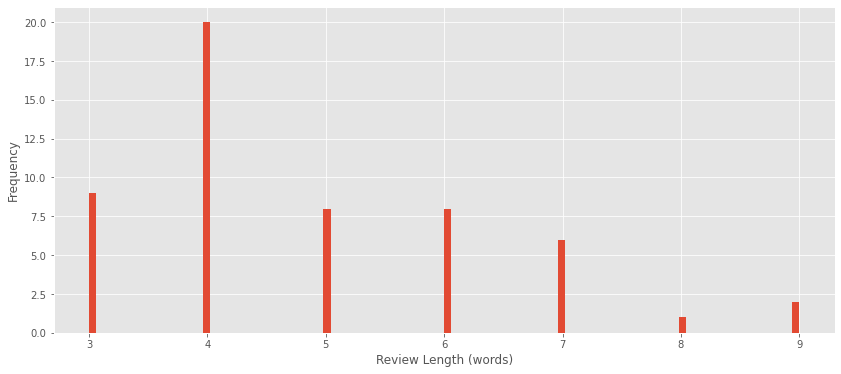

In [19]:
## Getting the number of words by splitting them by a space
words_per_review = spvl.Text.apply(lambda x: len(x.split(" ")))
words_per_review.hist(bins = 100)
plt.xlabel('Review Length (words)')
plt.ylabel('Frequency')
plt.show()

In [20]:
print('Average words:', words_per_review.mean())
print('Skewness:', words_per_review.skew())

Average words: 4.87037037037037
Skewness: 0.8809530055736419


Let's also look at the distribution of ratings:

In [24]:
percent_val = 100 * spvl['TAG'].value_counts()/len(spvl)
percent_val

0    48.148148
1    38.888889
2    12.962963
Name: TAG, dtype: float64

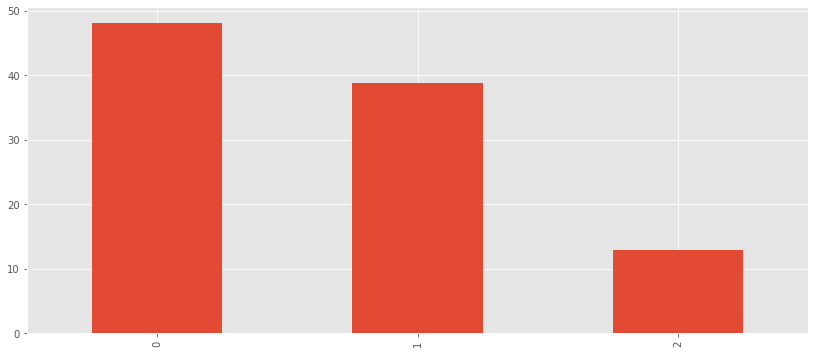

In [25]:
percent_val.plot.bar()
plt.show()

### Pre-processing
As discussed previously, text preprocessing and normalization is crucial before building a proper NLP model. Some of the important steps are:

1. Converting words to lower/upper case 
2. Removing special characters
3. Removing stopwords and high/low-frequency words
4. Stemming/lemmatization
### 1. Converting words to lower/upper case
Let's start by converting all of the words into a consistent case format, say lowercase:

In [26]:
spvl['reviews_text_new'] = spvl['Text'].str.lower()

In the following code cell we analyze the number of unique words that are found in reviews before and after applying this step. This process of extracting individual words is called word tokenization, and can be run using the word_tokenize function in the nltk package:

In [27]:
#For reviews not converted to lowe case
token_lists = [word_tokenize(each) for each in spvl['Text']]
tokens = [item for sublist in token_lists for item in sublist]
print("Number of unique tokens then: ",len(set(tokens)))

# For reviews converted to lowe case
token_lists_lower = [word_tokenize(each) for each in spvl['reviews_text_new']]
tokens_lower = [item for sublist in token_lists_lower for item in sublist]
print("Number of unique tokens now: ",len(set(tokens_lower)))

Number of unique tokens then:  118
Number of unique tokens now:  111


### Stopwords and high/low frequency words
As discussed before, stopwords naturally occur very frequently in the English language without adding any context specific insights. It makes sense to remove them. Let's first review what languages are available in the nltk package:

In [28]:
from nltk.corpus import stopwords

print('Available languages for NLTK v.3.4.5: ')
print(stopwords.fileids())

Available languages for NLTK v.3.4.5: 
['arabic', 'azerbaijani', 'danish', 'dutch', 'english', 'finnish', 'french', 'german', 'greek', 'hungarian', 'indonesian', 'italian', 'kazakh', 'nepali', 'norwegian', 'portuguese', 'romanian', 'russian', 'slovene', 'spanish', 'swedish', 'tajik', 'turkish']


Let's now review the list of English stopwords:

In [29]:
noise_words = []
eng_stop_words = stopwords.words('english')
eng_stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [30]:
stop_words = set(eng_stop_words)
without_stop_words = []
stopword = []
sentence = spvl['reviews_text_new'][0]
words = nltk.word_tokenize(sentence)

for word in words:
    if word in stop_words:
        stopword.append(word)
    else:
        without_stop_words.append(word)

print('-- Original Sentence --\n', sentence)
print('\n-- Stopwords in the sentence --\n', stopword)
print('\n-- Non-stopwords in the sentence --\n', without_stop_words)

-- Original Sentence --
 what is supervised learning

-- Stopwords in the sentence --
 ['what', 'is']

-- Non-stopwords in the sentence --
 ['supervised', 'learning']


Let's see how we omit these stopwords from our text:

In [31]:
def stopwords_removal(stop_words, sentence):
    return [word for word in nltk.word_tokenize(sentence) if word not in stop_words]

spvl['reviews_text_nonstop'] = spvl['reviews_text_new'].apply(lambda row: stopwords_removal(stop_words, row))
spvl[['reviews_text_new','reviews_text_nonstop']] 

,reviews_text_new,reviews_text_nonstop
0,what is supervised learning,"[supervised, learning]"
1,what is regression,[regression]
2,what is slope,[slope]
3,what is intercept,[intercept]
4,what is semi supervised learning,"[semi, supervised, learning]"
5,what is data split,"[data, split]"
6,what do you mean by the training of data,"[mean, training, data]"
7,what do you mean by the testing of data,"[mean, testing, data]"
8,what is the validation of model,"[validation, model]"
9,what is feature selection,"[feature, selection]"


Stemming works by cutting off the end or the beginning of the word, taking into account a list of common prefixes and suffixes that can be found.

Lemmatization takes into consideration the morphological analysis of the words. So lemmatization considers the grammar of the word and tries to find the root word instead of just getting to the root word by brute force methods.

In [32]:
from nltk.stem import PorterStemmer, LancasterStemmer # Common stemmers
from nltk.stem import WordNetLemmatizer # Common Lematizer
nltk.download('wordnet')
from nltk.corpus import wordnet

porter = PorterStemmer()
lancaster = LancasterStemmer()
lemmatizer = WordNetLemmatizer()

[nltk_data] Error loading wordnet: <urlopen error [Errno 11004]
[nltk_data]     getaddrinfo failed>


In [33]:
print("Lancaster Stemmer")
print(lancaster.stem("trouble"))
print(lancaster.stem("troubling"))
print(lancaster.stem("troubled"))

# Provide a word to be lemmatized
print("WordNet Lemmatizer")
print(lemmatizer.lemmatize("trouble", wordnet.NOUN))
print(lemmatizer.lemmatize("troubling", wordnet.VERB))
print(lemmatizer.lemmatize("troubled", wordnet.VERB))

Lancaster Stemmer
troubl
troubl
troubl
WordNet Lemmatizer
trouble
trouble
trouble



It can be seen that we get a meaning root word from Lemmatizer while Stemmer just cuts out and extracts the first important part of the word.

### Bag-of-words
The bag-of-words procedure falls under a broader category of techniques known as count-based representations. These are techniques to analyze documents by indicating how frequently certain types of structures occur throughout.

Let's start with 1-grams (words). The simplest type of information would be whether a particular word occurs in particular documents. This leads to word-document co-occurrence matrices, where the $(W, X)$ entry of the word-document matrix is set to 1 if word $W$ occurs in document $X$, and 0 otherwise.

Let's create a word-document co-occurrence matrix for our set of reviews using the CountVectorizer class that automatically accounts for certain preprocessing steps like removing stopwords, stemming, creating n-grams, and word tokenization:

In [36]:
# The following code creates a word-document matrix.
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer()
X = vec.fit_transform(spvl['reviews_text_new'])
df = pd.DataFrame(X.toarray(), columns = vec.get_feature_names())
df.head()

,accuracy,adjusted,affect,algorithm,assumption,auc,bayes,bias,boundary,by,...,tpr,trade,train,training,true,validation,variable,variance,what,you
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


Let's use this to create a bag of words from the reviews, excluding the noise words we identified earlier:

In [37]:
### Creating a python object of the class CountVectorizer

bow_counts = CountVectorizer(tokenizer= word_tokenize, # type of tokenization
                             stop_words=noise_words, # List of stopwords
                             ngram_range=(1,1)) # number of n-grams

bow_data = bow_counts.fit_transform(spvl['reviews_text_new'])

In [38]:
bow_data

<54x111 sparse matrix of type '<class 'numpy.int64'>'
	with 259 stored elements in Compressed Sparse Row format>

We can see that a sparse matrix of 259 observations (number of rows of the reviews_text_new series) has been built, and 17679 columns corresponding to the features extracted by means of the representation of the 1-gram count of the user reviews.

Once the bag of words is prepared, the dataset should be divided into training and test sets:

In [40]:
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(bow_data, # Features
                                                                    spvl['TAG'], # Target variable
                                                                    test_size = 0.2, # 20% test size
                                                                    random_state = 0) # random state for replication purposes

In [41]:
y_test_bow.value_counts()/y_test_bow.shape[0]


1    0.454545
0    0.454545
2    0.090909
Name: TAG, dtype: float64

In [42]:
from sklearn.naive_bayes import MultinomialNB
# use Naive Bayes to predict the star rating
nb = MultinomialNB()
nb.fit(X_train_bow, y_train_bow)
y_pred_class = nb.predict(X_test_bow)

In [44]:
# calculate accuracy
from sklearn import metrics
print (metrics.accuracy_score(y_test_bow, y_pred_class))
print(nb.score(X_test_bow,y_test_bow))

0.45454545454545453
0.45454545454545453


### TF-IDF model
Of course, bag-of-words are not the only way to featurize text. Another method is the Term Frequency-Inverse Document Frequency (TF-IDF) method. This evaluates how important a word is to a document within a large collection of documents (i.e. corpus). The importance increases proportionally based on the number of times a word appears in the document but is offset by the frequency of the word in the corpus.

The TF-IDF weight is the product of two terms. The first computes the normalized Term Frequency (TF); i.e. the number of times a word appears in a document divided by the total number of words in that document. The second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears:



Let's re-featurize our original set of reviews based on TF-IDF and split the resulting features into train and test sets:

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer

### Creating a python object of the class CountVectorizer
tfidf_counts = TfidfVectorizer(tokenizer= word_tokenize, # type of tokenization
                               stop_words=noise_words, # List of stopwords
                               ngram_range=(1,1)) # number of n-grams

tfidf_data = tfidf_counts.fit_transform(spvl['reviews_text_new'])

In [47]:
tfidf_data

<54x111 sparse matrix of type '<class 'numpy.float64'>'
	with 259 stored elements in Compressed Sparse Row format>

In [49]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(tfidf_data,
                                                                            spvl['TAG'],
                                                                            test_size = 0.2,
                                                                            random_state = 0)

In [50]:
### Setting up the model class
nb_tf_idf = MultinomialNB()

## Training the model 
nb_tf_idf.fit(X_train_tfidf,y_train_tfidf)

## Prediciting the results
test_pred_nb_all = nb_tf_idf.predict(X_test_tfidf)

## Evaluating the model
#print("F1 score: ",f1_score(y_test_bow, test_pred_lr_all))

# calculate accuracy
print (metrics.accuracy_score(y_test_tfidf, test_pred_nb_all))
print(nb.score(X_test_tfidf,y_test_tfidf))

0.5454545454545454
0.45454545454545453
